<a href="https://colab.research.google.com/github/ds-praveenkumar/machine-hack/blob/master/final_song_popularty_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import os
from math import sqrt
import numpy as np
import pandas as pd
import os


from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler,LabelEncoder,MinMaxScaler

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR

from sklearn.feature_extraction.text import TfidfVectorizer

import scipy

import string

import xgboost as xgb

import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

In [0]:
!wget -c 'https://www.machinehack.com/wp-content/uploads/2019/12/ChartbustersParticipantsData.zip'
!unzip 'ChartbustersParticipantsData.zip'
!ls -al

--2020-01-22 07:53:32--  https://www.machinehack.com/wp-content/uploads/2019/12/ChartbustersParticipantsData.zip
Resolving www.machinehack.com (www.machinehack.com)... 107.180.71.20
Connecting to www.machinehack.com (www.machinehack.com)|107.180.71.20|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5537700 (5.3M) [application/zip]
Saving to: ‘ChartbustersParticipantsData.zip’

ChartbustersPartici 100%[===================>]   5.28M  3.28MB/s    in 1.6s    

2020-01-22 07:53:34 (3.28 MB/s) - ‘ChartbustersParticipantsData.zip’ saved [5537700/5537700]

Archive:  ChartbustersParticipantsData.zip
   creating: ChartbustersParticipantsData/
  inflating: ChartbustersParticipantsData/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/ChartbustersParticipantsData/
  inflating: __MACOSX/ChartbustersParticipantsData/._.DS_Store  
  inflating: ChartbustersParticipantsData/Data_Train.csv  
  inflating: __MACOSX/ChartbustersParticipantsData/._Data_Train.csv  
  inflatin

In [0]:
os.chdir('ChartbustersParticipantsData')
train_df = pd.read_csv('Data_Train.csv')
test_df = pd.read_csv('Data_Test.csv')
submission = pd.read_excel('Sample_Submission.xlsx',encoding='latin-1')


In [0]:
def quick_analysis(df):
  print("Data Types:")
  print(df.dtypes)
  print('*'*100)
  print("Rows and Columns:")
  print(df.shape)
  print('*'*100)
  print("Column Names:")
  print(df.columns)
  print('*'*100)
  print("Null Values:")
  print(df.apply(lambda x: sum(x.isnull()) / len(df)))

In [0]:
train_df.shape, test_df.shape

((78458, 11), (19615, 10))

In [0]:
quick_analysis(train_df)

Data Types:
Unique_ID      int64
Name          object
Genre         object
Country       object
Song_Name     object
Timestamp     object
Views          int64
Comments       int64
Likes         object
Popularity    object
Followers      int64
dtype: object
****************************************************************************************************
Rows and Columns:
(78458, 11)
****************************************************************************************************
Column Names:
Index(['Unique_ID', 'Name', 'Genre', 'Country', 'Song_Name', 'Timestamp',
       'Views', 'Comments', 'Likes', 'Popularity', 'Followers'],
      dtype='object')
****************************************************************************************************
Null Values:
Unique_ID     0.000000
Name          0.000000
Genre         0.000000
Country       0.000000
Song_Name     0.000013
Timestamp     0.000000
Views         0.000000
Comments      0.000000
Likes         0.000000
Popularity    0

In [0]:
test_df.dtypes.value_counts()

object    7
int64     3
dtype: int64

In [0]:
train_df.dtypes.value_counts()

object    7
int64     4
dtype: int64

In [0]:
test_df['Datetime'] = pd.to_datetime(test_df.Timestamp)
test_df.drop('Timestamp',axis=1,inplace=True)
train_df['Datetime'] = pd.to_datetime(train_df.Timestamp)
train_df.drop('Timestamp',axis=1,inplace=True)

In [0]:
def date_part(df):
  """
  divides datetime column into different charactericts of the day
  """ 
  # Monday=0, Sunday=6
  dt_col = df.dtypes[df.dtypes == 'datetime64[ns]'].index.values[0] 

  df['DayOfWeek'] = df[dt_col].dt.dayofweek
  df['Month'] = df[dt_col].dt.month
  df['Hour'] = df[dt_col].dt.hour
  df['Week'] = df[dt_col].dt.week

date_part(train_df)
date_part(test_df)

In [0]:
def obj_num_convert(sting_val):
  if 'K' in str(sting_val) :
    val_lst = sting_val.split('.')
    val2 = val_lst[1].replace('K','0'*len(val_lst[1]))
    num = val_lst[0]+val2
    return num

def replace_character(df,to_replace,value):
  df.replace(regex=True,inplace=True,to_replace=to_replace,value=value)
  return df

def char_float_converter(x):
    if x.endswith('K') == True:
        return float(x.split('K')[0]) * 1000
    elif x.endswith('M') == True:
        return float(x.split('M')[0]) * 1000000
    else:
        return float(x)

In [0]:

replace_character(train_df['Likes'],',','')
replace_character(test_df['Likes'],',','')
train_df['Likes_conv'] = train_df.Likes.apply(char_float_converter)
train_df['Likes_conv']= train_df['Likes_conv'].astype(int)
test_df['Likes_conv'] = test_df.Likes.apply(char_float_converter)
test_df['Likes_conv']= test_df['Likes_conv'].astype(int)
train_df['Likes'] = train_df['Likes_conv']
test_df['Likes'] = test_df['Likes_conv']
del train_df['Likes_conv']
del test_df['Likes_conv']

In [0]:
replace_character(train_df['Popularity'],',','')
replace_character(test_df['Popularity'],',','')
train_df["Popularity"] = train_df["Popularity"].str.split("K").str[0].astype(float) * 1000
train_df["Popularity"] = train_df["Popularity"].astype(int)
test_df["Popularity"] = test_df["Popularity"].str.split("K").str[0].astype(float) * 1000
test_df["Popularity"] = test_df["Popularity"].astype(int)

In [0]:
train_df['Comments_Mul_Popularity'] = train_df.Comments * train_df.Popularity
train_df['Comments_Mul_Likes'] = train_df.Comments * train_df.Likes
train_df['Likes_Mul_Popularity'] = train_df.Likes * train_df.Popularity
train_df['Comments_by_Followers'] = train_df.Followers / train_df.Comments
train_df['Comments_by_Likes'] = train_df.Followers / train_df.Likes

In [0]:
test_df['Comments_Mul_Popularity'] = test_df.Comments * test_df.Popularity
test_df['Comments_Mul_Likes'] = test_df.Comments * test_df.Likes
test_df['Likes_Mul_Popularity'] = test_df.Likes * test_df.Popularity
test_df['Comments_by_Followers'] = test_df.Followers / test_df.Comments
test_df['Comments_by_Likes'] = test_df.Followers / test_df.Likes

In [0]:
le = LabelEncoder()
le.fit(train_df.Genre)
train_df['Genre_Encoded'] = le.transform(train_df.Genre)
le.fit(test_df.Genre)
test_df['Genre_Encoded'] = le.transform(test_df.Genre)

In [0]:
train_df['Song_Name_WC'] = train_df.Song_Name.astype(str).apply(lambda x: len(str(x).split()))
test_df['Song_Name_WC'] = test_df.Song_Name.astype(str).apply(lambda x: len(str(x).split()))
train_df['Song_Name_Num_Letters'] = train_df.Song_Name.astype(str).apply(lambda x : len(str(x)))
test_df['Song_Name_Num_Letters'] = test_df.Song_Name.astype(str).apply(lambda x : len(str(x)))
train_df['Song_Name_Num_Puntuations'] = train_df.Song_Name.astype(str).apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
test_df['Song_Name_Num_Puntuations'] = test_df.Song_Name.astype(str).apply(lambda x: len([c for c in str(x) if c in string.punctuation]))
train_df['Song_Name_Num_Upper_Words'] = train_df.Song_Name.astype(str).apply(lambda x: len([w for w in str(x).split() if w.isupper()]))
test_df['Song_Name_Num_Upper_Words'] = test_df.Song_Name.astype(str).apply(lambda x: len([w for w in str(x).split() if w.isupper()]))

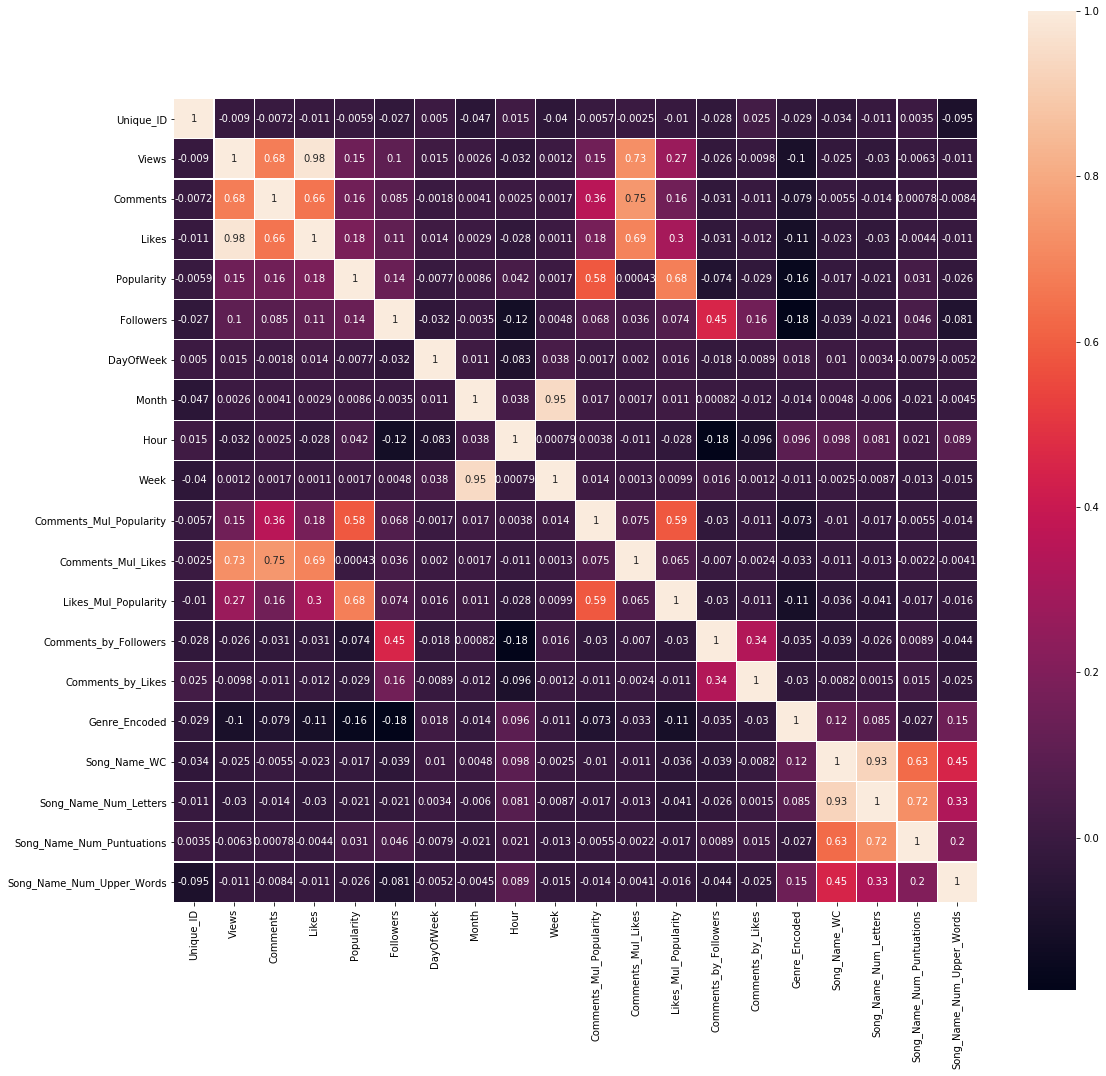

In [0]:
plt.figure(figsize=(18,18))
sns.heatmap(train_df.corr(),linewidths=0.1,linecolor='white',square=True, annot=True)

In [0]:
drop_columns = ['Unique_ID','Song_Name','Country','Views','Name','Genre','Datetime']
numeric_columns = [cols for cols in train_df.columns if cols not in drop_columns]

In [0]:
X = train_df.drop(columns=drop_columns ,axis=1)
y = train_df.Views

In [0]:
test_df1 = test_df.drop(columns=['Unique_ID','Song_Name','Country','Name','Genre','Datetime'],axis=1)

In [0]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.20,random_state=123)
print("="*50)
print("Train data size",X_train.shape)
print("Test data size",X_test.shape)
print("Target data size",y_train.shape)
print("Target Test data size",y_test.shape)

Train data size (62766, 18)
Test data size (15692, 18)
Target data size (62766,)
Target Test data size (15692,)


In [0]:
quick_analysis(X_train)

Data Types:
Comments                       int64
Likes                          int64
Popularity                     int64
Followers                      int64
DayOfWeek                      int64
Month                          int64
Hour                           int64
Week                           int64
Comments_Mul_Popularity        int64
Comments_Mul_Likes             int64
Likes_Mul_Popularity           int64
Comments_by_Followers        float64
Comments_by_Likes            float64
Genre_Encoded                  int64
Song_Name_WC                   int64
Song_Name_Num_Letters          int64
Song_Name_Num_Puntuations      int64
Song_Name_Num_Upper_Words      int64
dtype: object
****************************************************************************************************
Rows and Columns:
(62766, 18)
****************************************************************************************************
Column Names:
Index(['Comments', 'Likes', 'Popularity', 'Followers', 'DayOfW

In [0]:
quick_analysis(test_df)

Data Types:
Unique_ID                             int64
Name                                 object
Genre                                object
Country                              object
Song_Name                            object
Comments                              int64
Likes                                 int64
Popularity                            int64
Followers                             int64
Datetime                     datetime64[ns]
DayOfWeek                             int64
Month                                 int64
Hour                                  int64
Week                                  int64
Comments_Mul_Popularity               int64
Comments_Mul_Likes                    int64
Likes_Mul_Popularity                  int64
Comments_by_Followers               float64
Comments_by_Likes                   float64
Genre_Encoded                         int64
Song_Name_WC                          int64
Song_Name_Num_Letters                 int64
Song_Name_Num_Puntua

In [0]:
model = xgb.XGBRegressor(n_estimators=10000,random_state=123,objective="reg:squarederror",
                   eval_metric='rmse',learning_rate=0.04,n_jobs=-1)
print(model)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.04,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=10000, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)


In [0]:
%%time
model.fit(X_train,y_train)

/usr/local/lib/python3.6/dist-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, eval_metric='rmse',
             gamma=0, importance_type='gain', learning_rate=0.04,
             max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
             n_estimators=10000, n_jobs=-1, nthread=None,
             objective='reg:squarederror', random_state=123, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
             subsample=1, verbosity=1)

In [0]:
#predict = model.predict(X_test)

In [0]:
rmse = sqrt(mean_squared_error(y_test,predict))
rmse

In [0]:
predict_final = model.predict(test_df1)

In [0]:
p1 = np.clip(predict_final, 0, predict_final.max())
submission=pd.DataFrame()
submission['Unique_ID'] = test_df['Unique_ID']
submission['Views'] = p1
submission.to_excel('Submission.xlsx', index=False)

In [0]:
os.listdir('.')

['Sample_Submission.xlsx',
 'Submission.xlsx',
 'ChartbustersParticipantsData.zip',
 'ChartbustersParticipantsData',
 'Data_Test.csv',
 'Data_Train.csv',
 '.DS_Store',
 '__MACOSX']

# **Normalization**

In [0]:
X_train.columns.where(X_train[X_train.dtypes.values == 'float64'])

Index([                    nan,                     nan,
                           nan,                     nan,
                           nan,                     nan,
                           nan,                     nan,
                           nan,                     nan,
                           nan, 'Comments_by_Followers',
           'Comments_by_Likes',                     nan,
                           nan,                     nan,
                           nan,                     nan],
      dtype='object')

In [0]:
minmax = MinMaxScaler(feature_range=(-1,1))
minmax.fit(X_train)


ValueError: ignored

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [0]:
svr_rbf = SVR(kernel='rbf', C=100, gamma=0.1, epsilon=.1)
svr_poly = SVR(kernel='poly', C=100, gamma='auto', degree=3, epsilon=.1,
               coef0=1)

In [0]:
%%time
svr_poly_predict = svr_poly.fit(X_train,y_train)
svr_poly_rmse = sqrt(mean_squared_error(y_test,svr_poly_predict))
svr_poly_rmse

ValueError: ignored

In [0]:
%%time
svr_rbf_predict = svr_rbf.fit(X_train,y_train)
svr_rbf_rmse = sqrt(mean_squared_error(y_test,svr_rbf_predict))
svr_rbf_rmse

In [0]:
p1 = np.clip(predict, 0, predict.max())

In [0]:
submission=pd.DataFrame()
submission['Unique_ID'] = test['Unique_ID']
submission['Views'] = p1
submission.to_excel('Submission.xlsx', index=False)